# Pre-processing and Modeling

* [1. Pre-processing](#1)
    * [1.1 The goal](#1.1)
    * [1.2 Input files](#1.2)
    * [1.3 Select subsample of users](#1.3)
    * [1.4 One-hot encode products](#1.4)
    * [1.5 Prepare X array](#1.5)
    * [1.6 Prepare y array](#1.6)
* [2. Modeling](#2)
    * [2.1 Mean-F1-score metrics function](#2.1)
    * [2.2 Baseline model](#2.2)
    * [2.3 A simple GRU](#2.3)
    * [2.4 A simple LSTM](#2.4)
    * [2.5 bidirectional GRU](#2.5)
    * [2.6 Bidirectional LSTM](#2.6)
    * [2.7 Stacked LSTM](#2.7)
    * [2.8 Summary](#2.8)

In [1]:
import pandas as pd
import numpy as np
import matplotlib as mpl # colors
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import seaborn as sns
from datetime import datetime as dt
import pickle
import sys

plt.rcParams['axes.grid'] = True
plt.rcParams['axes.axisbelow'] = True
plt.rcParams['axes.xmargin'] = 0.02
plt.rcParams['axes.ymargin'] = 0.1
plt.rcParams['xtick.minor.visible'] = True
plt.rcParams['ytick.minor.visible'] = True

plt.rcParams['figure.dpi'] = 100
plt.rcParams['savefig.bbox'] = 'tight'

In [2]:
n_customers = 50_000 # how many customers (130k total)
n_products = 1000    # how many products allowed per order # 1000 was too much for memory, had to use dask
last_n_orders = 20   # how many last orders to consider 

We are trying to predict the customer's next basket content using reccurent neural network based on the Gated Recurrent Unit (GRU) and Long Short-Term Memory (LSTM) models. In the first part of this notebook we prepare the data, the second part covers the modeling.

## 1. Pre-processing <a id='1'></a>

### 1.1 The goal <a id='1.1'></a>

model(X) = y

The input X to the LSTM model is a 3-D array (experiments, time_dependence, features), while the output y is a 2-D array (experiments,features). The time_depedence and features vectors need to be of the same size for each entry from experiments. 

In our case, the desired input and output data should be of the format X=(clients,orders,products_OHE) and y=(clients,products_OHE_sigmax), respectively. Here, products_OHE stands for one-hot-encoded product list. One-hot encouding will allow us to define the modeling as a classification problem. The limitation is that we cannot one-hot-encode 75k available products, as it is beyond a memory of our computer. To check the performance of the RNNs we will use here only 1k products that are the most popular products accounting for 60% of the puchases.


The number of orders per customer may vary from 4 to 99. To assume a fixed size of the input tensor we will use only the last 20 customer's orders. IF the number of previous orders is smaller than 20, we will fill the remaining part of the orders dimension with zeros. We checked that number 20 is suffient to include all the products from customer's history into modeling.

### 1.2 Input files <a id='1.2'></a>

Let's read in the files, set up some memory control and select from the file orders only those orders that correspond to train sample (prior and next orders).

In [3]:
orders         = pd.read_csv("./data/orders.csv",usecols=['order_id','user_id','eval_set','order_number'])
products_prior = pd.read_csv("./data/order_products__prior.csv")
products_train = pd.read_csv("./data/order_products__train.csv")
#products_sub   = pd.read_csv("./data/sample_submission.csv")

print(orders.shape)
print(products_prior.shape) 
print(products_train.shape) 
#print(products_sub.shape)

(3421083, 4)
(32434489, 4)
(1384617, 4)


In [4]:
def size(x,n=2):
    return '{} G'.format(round(sys.getsizeof(x)/1_000_000_000.,n))

In [5]:
print(size(orders))
print(size(products_prior))
print(size(products_train))

0.29 G
1.04 G
0.04 G


In [6]:
round(orders.memory_usage(deep=True).sum()/1_000_000_000.,2)

0.29

In [7]:
orders.head(15)

,order_id,user_id,eval_set,order_number
0,2539329,1,prior,1
1,2398795,1,prior,2
2,473747,1,prior,3
3,2254736,1,prior,4
4,431534,1,prior,5
5,3367565,1,prior,6
6,550135,1,prior,7
7,3108588,1,prior,8
8,2295261,1,prior,9
9,2550362,1,prior,10


In [8]:
products_prior.head()

,order_id,product_id,add_to_cart_order,reordered
0,2,33120,1,1
1,2,28985,2,1
2,2,9327,3,0
3,2,45918,4,1
4,2,30035,5,0


In [9]:
products_train.head()

,order_id,product_id,add_to_cart_order,reordered
0,1,49302,1,1
1,1,11109,2,1
2,1,10246,3,0
3,1,49683,4,0
4,1,43633,5,1


In [10]:
products_prior.shape, products_train.shape

((32434489, 4), (1384617, 4))

### 1.3 Select subsample of users <a id='1.3'></a>

Let's separate the "orders" dataframe into customers whose data are used for training and for testing/prediction and select only those for training:

In [11]:
uid = orders.groupby('user_id')['eval_set'].unique()
uid

user_id
1         [prior, train]
2         [prior, train]
3          [prior, test]
4          [prior, test]
5         [prior, train]
               ...      
206205    [prior, train]
206206     [prior, test]
206207     [prior, test]
206208     [prior, test]
206209    [prior, train]
Name: eval_set, Length: 206209, dtype: object

In [12]:
uid.astype('str').str.contains('train')

user_id
1          True
2          True
3         False
4         False
5          True
          ...  
206205     True
206206    False
206207    False
206208    False
206209     True
Name: eval_set, Length: 206209, dtype: bool

In [13]:
uid_train = uid[uid.astype('str').str.contains('train')].reset_index()
uid_train = uid_train.drop('eval_set',axis=1)
uid_train

,user_id
0,1
1,2
2,5
3,7
4,8
...,...
131204,206199
131205,206200
131206,206203
131207,206205


In [14]:
size(uid_train,3)

'0.001 G'

__We have 130k customers, let's choose only n_customers = 50k of them:__

In [15]:
uid_train_reduced = uid_train.head(n_customers)
uid_train_reduced.shape

(50000, 1)

Now, let's merge it back with orders. The result will contain only prior and future order in training sample. We got rid of test subsample (both prior and next orders).

In [16]:
orders_train = uid_train_reduced.merge(orders,on='user_id',how='left')
orders_train.head(50)

,user_id,order_id,eval_set,order_number
0,1,2539329,prior,1
1,1,2398795,prior,2
2,1,473747,prior,3
3,1,2254736,prior,4
4,1,431534,prior,5
5,1,3367565,prior,6
6,1,550135,prior,7
7,1,3108588,prior,8
8,1,2295261,prior,9
9,1,2550362,prior,10


In [17]:
orders_train.shape; size(orders_train)

'0.08 G'

In [18]:
reduced_list_orders_id = orders_train['order_id'].values
print(len(reduced_list_orders_id),reduced_list_orders_id)

835132 [2539329 2398795  473747 ...  105919 3407928   65330]


### 1.4 One-hot-encode products <a id='1.4'></a>

#### 1.3.1 How many products in orders for this subsample? <a id='1.3.1'></a>

In [19]:
products_prior_reduced = products_prior[products_prior['order_id'].isin(reduced_list_orders_id)]
products_train_reduced = products_train[products_train['order_id'].isin(reduced_list_orders_id)]

How many products are exclusively in the train sample?

In [20]:
p = set(products_prior_reduced['product_id'].values)
t = set(products_train_reduced['product_id'].values)
len(p),len(t)

(46803, 30799)

In [21]:
len(p - t), len(t - p)

(16364, 360)

360 exclusively in train. Let's merge the files to properly apply one-hot-ecouding later.

In [22]:
# now only reordered

In [23]:
products_prior_reduced = products_prior_reduced[products_prior_reduced['reordered']==1]
products_train_reduced = products_train_reduced[products_train_reduced['reordered']==1]
products_prior_reduced.shape, products_train_reduced.shape

((4683848, 4), (317623, 4))

In [24]:
print(size(products_prior_reduced))
print(size(products_train_reduced))

0.19 G
0.01 G


In [25]:
p = set(products_prior_reduced['product_id'].values)
t = set(products_train_reduced['product_id'].values)
len(p),len(t)

(35941, 22547)

In [26]:
len(p - t), len(t - p)

(14037, 643)

640 exclusively in train now

In [27]:
products = pd.concat((products_prior_reduced,products_train_reduced))
products.shape

(5001471, 4)

In [28]:
print(size(products))

0.2 G


In [29]:
products['product_id'].value_counts().shape

(36584,)

36k unique products for 50k users (45k for all users), but let's select only the first 10k most frequently ordered now.

In [30]:
products['product_id'].value_counts()

24852    104157
13176     81473
21137     53016
21903     49275
47209     45308
          ...  
6093          1
11788         1
33477         1
37575         1
41712         1
Name: product_id, Length: 36584, dtype: int64

In [31]:
n = 36584
x = range(n)
y = products['product_id'].value_counts().values

histogram:

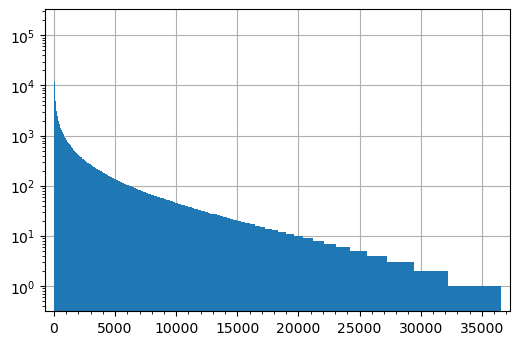

In [32]:
plt.hist(x,weights=y,bins=n,log=True);

cumulative distribution:

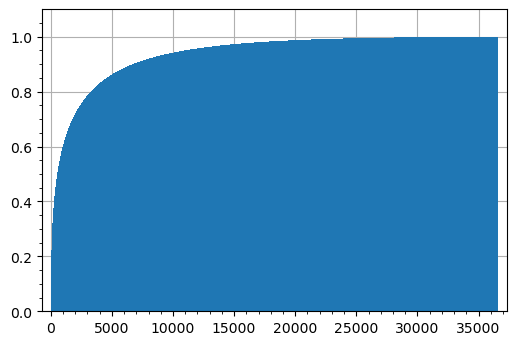

In [33]:
plt.hist(x,weights=y,bins=n,density=True,cumulative=True);

zoom it:

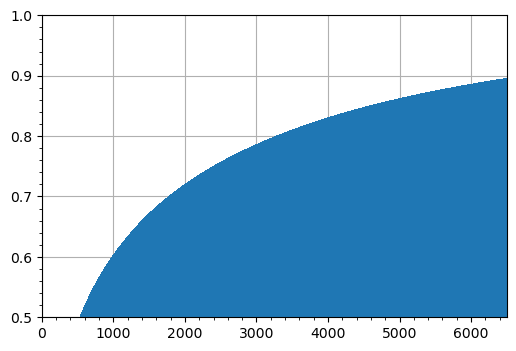

In [34]:
plt.hist(x,weights=y,bins=n,density=True,cumulative=True);plt.xlim((0.,6500.));plt.ylim((0.5,1.));

In [35]:
# for all users, all orders
# 2000 - 72% working but very slow
# 1500 - 65% same slow
# 1000 - 60%
#  600 - 50% 

# the same fractions for reduced sample too, but there ARE! less products

#### 1.3.2 One-hot-encode the most popular products <a id='1.3.2'></a>

We will use only the first 1k products. Due to memory limitation, but they account for 60% of purchases.

In [36]:
topn = products['product_id'].value_counts().head(n_products).index
len(topn),topn

(1000,
 Int64Index([24852, 13176, 21137, 21903, 47209, 47766, 27845, 47626, 27966,
             16797,
             ...
             40001, 35168,  3849, 35199, 30850, 14267, 27020, 13866,  3873,
             47492],
            dtype='int64', length=1000))

In [37]:
products = products[products['product_id'].isin(topn)]
products.shape, size(products)

((3023205, 4), '0.12 G')

In [38]:
products['product_id'].nunique()

1000

In [39]:
products = products.drop(['add_to_cart_order','reordered'],axis=1)

In [40]:
products.head()

,order_id,product_id
126,14,27845
128,14,2452
131,14,39475
134,14,20995
188,22,23909


In [41]:
products.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3023205 entries, 126 to 1384552
Data columns (total 2 columns):
 #   Column      Dtype
---  ------      -----
 0   order_id    int64
 1   product_id  int64
dtypes: int64(2)
memory usage: 69.2 MB


Before encoding, let's reduce the memory usage and convert the product_id type to the safest smaller uint number (uint16)

In [42]:
products['order_id'].min(),products['order_id'].max()

(14, 3421080)

In [43]:
products['product_id'].min(),products['product_id'].max()

(34, 49683)

In [44]:
# Int8 — [-128 : 127]
# Int16 — [-32768 : 32767]
# Int32 — [-2147483648 : 2147483647]
# Int64 — [-9223372036854775808 : 9223372036854775807]
#
# UInt8 — [0 : 255]
# UInt16 — [0 : 65535]
# UInt32 — [0 : 4294967295]

In [45]:
products['order_id'] = products['order_id'].astype('uint32')
products['product_id'] = products['product_id'].astype('uint16')

In [46]:
products.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3023205 entries, 126 to 1384552
Data columns (total 2 columns):
 #   Column      Dtype 
---  ------      ----- 
 0   order_id    uint32
 1   product_id  uint16
dtypes: uint16(1), uint32(1)
memory usage: 40.4 MB


One-hot encode now:

In [47]:
def hot_encode(df,cols):
    return pd.get_dummies(df,columns=cols)

In [48]:
%%time
products_ohe_0 = hot_encode(products,['product_id'])

CPU times: user 55.3 s, sys: 5.04 s, total: 1min
Wall time: 1min


In [49]:
# dtypes: uint32(1), uint8(2000)
# memory usage: 6.8 GB
products_ohe_0.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3023205 entries, 126 to 1384552
Columns: 1001 entries, order_id to product_id_49683
dtypes: uint32(1), uint8(1000)
memory usage: 2.8 GB


In [50]:
import dask.dataframe as dd
def ohe_sum_products_over_orders(x):
    df = dd.from_pandas(x,npartitions=2000) # 100 for 1k products, 2000 for 2k products didn't work
    return df.groupby('order_id').sum().compute()

this above is the bottle neck, the memory is saturated and the notebook shutsdown for any number > 1000. That's why we go with 1000.

In [51]:
products_ohe = ohe_sum_products_over_orders(products_ohe_0)

In [52]:
del products_ohe_0

In [53]:
type(products_ohe)

pandas.core.frame.DataFrame

In [54]:
products_ohe.info()

<class 'pandas.core.frame.DataFrame'>
UInt64Index: 659580 entries, 14 to 3421080
Columns: 1000 entries, product_id_34 to product_id_49683
dtypes: uint8(1000)
memory usage: 634.1 MB


In [55]:
products_ohe.head(20)

,product_id_34,product_id_45,product_id_196,product_id_260,product_id_311,product_id_329,product_id_365,product_id_432,product_id_581,product_id_651,...,product_id_49235,product_id_49247,product_id_49383,product_id_49416,product_id_49478,product_id_49520,product_id_49533,product_id_49610,product_id_49621,product_id_49683
order_id,,,,,,,,,,,,,,,,,,,,,
14,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
22,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
23,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
25,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
38,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
40,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
45,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
56,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
65,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [56]:
size(products_ohe)

'0.66 G'

In [57]:
#(10383795, 601)
products_ohe.shape

(659580, 1000)

In [58]:
products_ohe.info()

<class 'pandas.core.frame.DataFrame'>
UInt64Index: 659580 entries, 14 to 3421080
Columns: 1000 entries, product_id_34 to product_id_49683
dtypes: uint8(1000)
memory usage: 634.1 MB


In [59]:
with open('./data/products_ohe_reduced_{}.pkl'.format(n_products), 'wb') as f:
        pickle.dump(products_ohe, f)

In [60]:
#with open('./data/products_ohe_reduced_{}.pkl'.format(n_products), 'rb') as f: 
#        products_ohe = pickle.load(f)

Finally, split into X and y. X corresponds to prior orders, y to train orders (if confused, think of "train" as "next" orders in the train sample).

In [61]:
orders_train_X = orders_train[orders_train['eval_set']=='prior'].drop('eval_set',axis=1)
orders_train_y = orders_train[orders_train['eval_set']=='train'].drop('eval_set',axis=1)

print(orders_train_X.shape,orders_train_y.shape)

(785132, 3) (50000, 3)


In [62]:
size(orders_train_X),size(orders_train_y,3)

('0.03 G', '0.002 G')

In [63]:
del orders_train

### 1.5 Prepare X array <a id='1.5'></a>

In [64]:
orders_train_X.head(30)

,user_id,order_id,order_number
0,1,2539329,1
1,1,2398795,2
2,1,473747,3
3,1,2254736,4
4,1,431534,5
5,1,3367565,6
6,1,550135,7
7,1,3108588,8
8,1,2295261,9
9,1,2550362,10


We want only last_n_orders. Reverse order_number and cut <= 20

In [65]:
orders_train_X['order_number'] = orders_train_X.groupby('user_id').cumcount(ascending=False) + 1
orders_train_X.head(20)

,user_id,order_id,order_number
0,1,2539329,10
1,1,2398795,9
2,1,473747,8
3,1,2254736,7
4,1,431534,6
5,1,3367565,5
6,1,550135,4
7,1,3108588,3
8,1,2295261,2
9,1,2550362,1


In [66]:
orders_train_X = orders_train_X[orders_train_X['order_number'] <= last_n_orders]
orders_train_X.shape

(553319, 3)

In [67]:
size(orders_train_X)

'0.02 G'

And reverse order_number back to the original numbers

In [68]:
orders_train_X.head(20)

,user_id,order_id,order_number
0,1,2539329,10
1,1,2398795,9
2,1,473747,8
3,1,2254736,7
4,1,431534,6
5,1,3367565,5
6,1,550135,4
7,1,3108588,3
8,1,2295261,2
9,1,2550362,1


In [69]:
orders_train_X['order_number'] = orders_train_X.groupby('user_id').cumcount(ascending=False) + 1

In [70]:
orders_train_X = orders_train_X.pivot(index='user_id',columns='order_number',values='order_id').fillna(0).astype('uint')
orders_train_X.head(20)

order_number,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20
user_id,,,,,,,,,,,,,,,,,,,,
1,2550362,2295261,3108588,550135,3367565,431534,2254736,473747,2398795,2539329,0,0,0,0,0,0,0,0,0,0
2,839880,3268552,3186735,1402090,1447487,1718559,788338,3194192,1199898,1673511,738281,1901567,1501582,2168274,0,0,0,0,0,0
5,157374,2267326,1909121,2717275,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
7,2452257,369015,2984707,23391,2425840,3120740,3060817,1175028,3239072,565870,1396119,2507052,776265,1014379,1682003,3321109,1695742,121053,2402008,2565571
8,2570360,2979257,600894,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
9,1830137,2762092,280530,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
10,1353310,83395,2115522,68288,1224907,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
13,1789302,1472646,2298068,519471,1757094,1906169,2363981,1378982,19256,2288946,2560699,2618231,0,0,0,0,0,0,0,0
14,3394109,2045336,1335295,1625325,2109666,3067644,2505309,2127409,1691859,1385564,1366559,3206747,2906263,0,0,0,0,0,0,0


In [71]:
orders_train_X = orders_train_X[orders_train_X.columns[::-1]].stack()
orders_train_X.name = 'order_id'
orders_train_X = orders_train_X.reset_index()

In [72]:
orders_train_X.head(40)

,user_id,order_number,order_id
0,1,20,0
1,1,19,0
2,1,18,0
3,1,17,0
4,1,16,0
5,1,15,0
6,1,14,0
7,1,13,0
8,1,12,0
9,1,11,0


In [73]:
orders_train_X.groupby('user_id')['order_number'].count().head()

user_id
1    20
2    20
5    20
7    20
8    20
Name: order_number, dtype: int64

In [74]:
orders_train_X = orders_train_X.drop('order_number',axis=1)
orders_train_X.head(40)

,user_id,order_id
0,1,0
1,1,0
2,1,0
3,1,0
4,1,0
5,1,0
6,1,0
7,1,0
8,1,0
9,1,0


In [75]:
orders_train_X.shape,size(orders_train_X)

((1000000, 2), '0.02 G')

In [76]:
orders_train_X.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000000 entries, 0 to 999999
Data columns (total 2 columns):
 #   Column    Non-Null Count    Dtype 
---  ------    --------------    ----- 
 0   user_id   1000000 non-null  int64 
 1   order_id  1000000 non-null  uint64
dtypes: int64(1), uint64(1)
memory usage: 15.3 MB


In [77]:
orders_train_X['order_id'].min(),orders_train_X['order_id'].max()

(0, 3421072)

What's the highest value? 

In [78]:
orders_train_X['user_id'].max()

78707

We can easily convert typefrom uint64 to uint8. 

Let's first merge X with products, then covert to uint8.

In [79]:
def merge(x,p):
    return x.merge(p,on='order_id',how='left').fillna(0).astype('uint')

In [80]:
orders_train_X = merge(orders_train_X,products_ohe)

In [81]:
orders_train_X.head(20)

,user_id,order_id,product_id_34,product_id_45,product_id_196,product_id_260,product_id_311,product_id_329,product_id_365,product_id_432,...,product_id_49235,product_id_49247,product_id_49383,product_id_49416,product_id_49478,product_id_49520,product_id_49533,product_id_49610,product_id_49621,product_id_49683
0,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
5,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
6,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
7,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
8,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
9,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [82]:
orders_train_X.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1000000 entries, 0 to 999999
Columns: 1002 entries, user_id to product_id_49683
dtypes: uint64(1002)
memory usage: 7.5 GB


In [83]:
for col in orders_train_X.columns[2:]:
    orders_train_X[col] = orders_train_X[col].astype('uint8')

In [84]:
orders_train_X.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1000000 entries, 0 to 999999
Columns: 1002 entries, user_id to product_id_49683
dtypes: uint64(2), uint8(1000)
memory usage: 976.6 MB


### 1.6 Prepare y array <a id='1.6'></a>

Let's repeate the same steps for the y array. This one should be much quicker, as it has one less dimension to consider.

In [85]:
size(orders_train_y,3)

'0.002 G'

In [86]:
orders_train_y

,user_id,order_id,order_number
10,1,1187899,11
25,2,1492625,15
30,5,2196797,5
51,7,525192,21
55,8,880375,4
...,...,...,...
835072,78702,3048078,9
835077,78703,1260736,5
835081,78704,2700517,4
835120,78705,2160403,39


In [87]:
orders_train_y = orders_train_y.drop('order_number',axis=1)

In [88]:
orders_train_y.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 50000 entries, 10 to 835131
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype
---  ------    --------------  -----
 0   user_id   50000 non-null  int64
 1   order_id  50000 non-null  int64
dtypes: int64(2)
memory usage: 1.1 MB


In [89]:
orders_train_y['order_id'].min(),orders_train_y['order_id'].max()

(38, 3420996)

In [90]:
orders_train_y['user_id'].max()

78707

In [91]:
orders_train_y = merge(orders_train_y,products_ohe)

In [92]:
orders_train_y.head(20)

,user_id,order_id,product_id_34,product_id_45,product_id_196,product_id_260,product_id_311,product_id_329,product_id_365,product_id_432,...,product_id_49235,product_id_49247,product_id_49383,product_id_49416,product_id_49478,product_id_49520,product_id_49533,product_id_49610,product_id_49621,product_id_49683
0,1,1187899,0,0,1,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0
1,2,1492625,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,5,2196797,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,7,525192,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,8,880375,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
5,9,1094988,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
6,10,1822501,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
7,13,1827621,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
8,14,2316178,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
9,17,2180313,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [93]:
orders_train_y.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 50000 entries, 0 to 49999
Columns: 1002 entries, user_id to product_id_49683
dtypes: uint64(1002)
memory usage: 382.6 MB


In [94]:
for col in orders_train_y.columns[2:]:
    orders_train_y[col] = orders_train_y[col].astype('uint8')

In [95]:
orders_train_y.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 50000 entries, 0 to 49999
Columns: 1002 entries, user_id to product_id_49683
dtypes: uint64(2), uint8(1000)
memory usage: 48.8 MB


### 1.7 Numpy X and y, saving to file <a id='1.7'></a>

In [96]:
xval = orders_train_X.groupby('user_id')['user_id'].head(1).values
yval = orders_train_y['user_id'].values
set(xval ==yval)

{True}

In [97]:
orders_train_X = orders_train_X.drop(['user_id','order_id'],axis=1)
orders_train_y = orders_train_y.drop(['user_id','order_id'],axis=1)

In [98]:
orders_train_X.head()

,product_id_34,product_id_45,product_id_196,product_id_260,product_id_311,product_id_329,product_id_365,product_id_432,product_id_581,product_id_651,...,product_id_49235,product_id_49247,product_id_49383,product_id_49416,product_id_49478,product_id_49520,product_id_49533,product_id_49610,product_id_49621,product_id_49683
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [99]:
orders_train_y.head()

,product_id_34,product_id_45,product_id_196,product_id_260,product_id_311,product_id_329,product_id_365,product_id_432,product_id_581,product_id_651,...,product_id_49235,product_id_49247,product_id_49383,product_id_49416,product_id_49478,product_id_49520,product_id_49533,product_id_49610,product_id_49621,product_id_49683
0,0,0,1,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [100]:
orders_train_X.shape,orders_train_y.shape

((1000000, 1000), (50000, 1000))

In [101]:
size(orders_train_X),size(orders_train_y)

('1.01 G', '0.05 G')

In [102]:
orders_train_X.min().min(),orders_train_X.max().max()

(0, 1)

In [103]:
orders_train_y.min().min(),orders_train_y.max().max()

(0, 1)

In [104]:
orders_train_X.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1000000 entries, 0 to 999999
Columns: 1000 entries, product_id_34 to product_id_49683
dtypes: uint8(1000)
memory usage: 961.3 MB


In [105]:
orders_train_y.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 50000 entries, 0 to 49999
Columns: 1000 entries, product_id_34 to product_id_49683
dtypes: uint8(1000)
memory usage: 48.1 MB


In [106]:
X = orders_train_X.to_numpy()
y = orders_train_y.to_numpy()

In [107]:
print(X.nbytes/10**9,'G,',y.nbytes/10**9,'G')

1.0 G, 0.05 G


In [108]:
#cols = orders_train_X.columns
pids = [col.split("_")[-1] for col in orders_train_X.columns]
print(pids[:15])

['34', '45', '196', '260', '311', '329', '365', '432', '581', '651', '781', '890', '1025', '1090', '1158']


In [109]:
with open('./data/pids_for_cols_reduced_{}.pkl'.format(n_products), 'wb') as f:
        pickle.dump(pids, f)

In [110]:
del orders_train_X
del orders_train_y

What about the shape?

In [111]:
X.shape, y.shape

((1000000, 1000), (50000, 1000))

We need to reshape it to the desired 3-D format:

In [112]:
X = np.reshape(X,(-1,last_n_orders,n_products))
X.shape,y.shape

((50000, 20, 1000), (50000, 1000))

Save them to a file:

In [113]:
with open('./data/xy_train_reduced_{}.pkl'.format(n_products), 'wb') as f:
        pickle.dump((X,y), f)

In [ ]:
#!ls -lrt ./data/**pkl

## 2. Modeling <a id='2'></a>

Let's prepare the libraries to run the simplest LSTM model.

In [3]:
from sklearn.model_selection import train_test_split
import tensorflow as tf
from keras.models import Sequential
from keras.layers import LSTM
from keras.layers import GRU
from keras.layers import Bidirectional
from keras.layers import Dense
from keras.layers import RepeatVector
#from keras.layers import TimeDistributed

from keras.callbacks import EarlyStopping
from keras.models import load_model

In [4]:
with open('./data/xy_train_reduced_{}.pkl'.format(n_products), 'rb') as f: 
        X,y = pickle.load(f)

In [5]:
X.shape,y.shape

((50000, 20, 1000), (50000, 1000))

In [6]:
print(X.nbytes/10**9,y.nbytes/10**9,'G')

1.0 0.05 G


Let's split the data, assigning 25% of the training samples for a local model testing.

In [7]:
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.25,random_state=123)

In [8]:
del X, y

In [9]:
X_train.shape,y_train.shape

((37500, 20, 1000), (37500, 1000))

In [10]:
X_test.shape,y_test.shape

((12500, 20, 1000), (12500, 1000))

### 2.1 Mean-F1-score metrics function <a id='2.1'></a>

Let's prepare the metrics to check the performance of models.

In [11]:
def individual_score(y_true, y_pred):
    
    len_true = np.dot(y_true,y_true)
    len_pred = np.dot(y_pred,y_pred)
    len_comm = np.dot(y_true,y_pred)
        
    # both empty
    if len_true + len_pred == 0:
        return 1.,1.,1.

    # nothing in common (includes both: none vs sth and sth vs none, so no division by zero 
    if len_comm == 0: 
        return 0.,0.,0.
    
    p = 1. * len_comm / len_pred
    r = 1. * len_comm / len_true
    
    return p, r, 2 * p * r / (p + r)
    
def mean_precision_score(y_true, y_pred):

    return np.mean([individual_score(x, y)[0] for x, y in zip(y_true, y_pred)])    
    
def mean_recall_score(y_true, y_pred):

    return np.mean([individual_score(x, y)[1] for x, y in zip(y_true, y_pred)])       
    
def mean_f1_score(y_true, y_pred):

    return np.mean([individual_score(x, y)[2] for x, y in zip(y_true, y_pred)])

In [12]:
print(mean_f1_score([0,0],[0,0]),mean_f1_score([[1,0],[0,0]],[[0,0],[0,0]]),mean_f1_score([[0,0],[1,0]],[[1,1],[0,1]]))

1.0 0.5 0.0


### 2.2 Baseline model <a id='2.2'></a>

Our baseline model will be to copy the customer's last order as a prediction. What's the score of this?:

For train sample:

In [13]:
y_train_pred = X_train[:,-1,:]
round(mean_f1_score(y_train,y_train_pred),3)

0.382

For test sample:

In [14]:
y_test_pred = X_test[:,-1,:]
round(mean_f1_score(y_test,y_test_pred),3)

0.385

Similar results, the score is 0.385 for the test sample. And what if we copy from earlier orders?:

In [15]:
x = np.linspace(1,20,20); y = []

for i in range(1,21):
        
    y_test_pred  = X_test[:,-i,:]
    y.append(mean_f1_score(y_test ,y_test_pred))

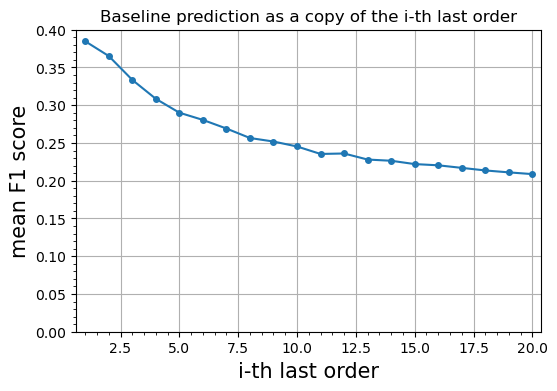

In [16]:
plt.rcParams.update({'axes.labelsize': 15})

plt.plot(x,y,marker='o',markersize=4); plt.ylim(0,0.4)

plt.title('Baseline prediction as a copy of the i-th last order')
plt.xlabel('i-th last order'); plt.ylabel('mean F1 score');

Ha! Seems like the customer's memory fades away and preference changes with time. If we were to use the 8th last order as the prediction, the score would drop down by half.

What if we sum up the last n orders, for n varying from 1 to 20:

In [17]:
x = np.linspace(1,20,20); z = []

for i in range(1,21):
    
    X_test_reduced = X_test[:,-i:,:]
    X_test_ln = np.sum(X_test_reduced,axis=1)
    z.append(mean_f1_score(y_test ,X_test_ln))

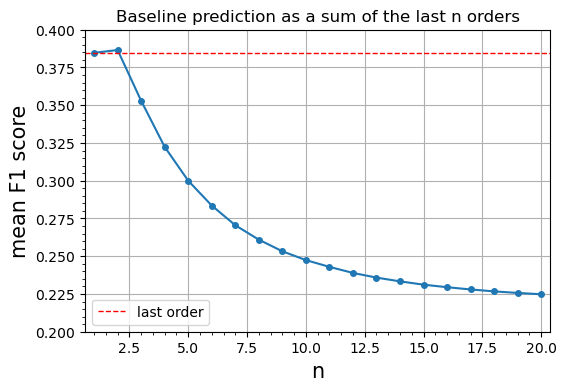

In [18]:
plt.rcParams.update({'axes.labelsize': 15})

plt.plot(x,z,marker='o',markersize=4); 
plt.ylim(0.2,0.4)

plt.title('Baseline prediction as a sum of the last n orders')
plt.xlabel('n'); plt.ylabel('mean F1 score');
plt.axhline(z[0],c='r',linestyle='--',linewidth=1,label='last order');
plt.legend();

In [19]:
round(z[np.argmax(z)],3)

0.387

The highest score if we sum two last orders!

OK, let's move to deep learing now. 

Before we start model implementations, let's define the early stopping callback, which we will use for all the models we'll try below. It will stop training if the score doesn't improve after patience=3 consequtive interactions. Let's also prepare two plotting functons. 

In [20]:
callback = EarlyStopping(patience=5,restore_best_weights=True)

In [21]:
def plot_loss(h):
    fig, ax = plt.subplots(1,1,figsize=(6,4))

    #skip the very first one, to avoid high train
    ax.plot(h.history['loss'][1:],marker='o',markersize=4)
    ax.plot(h.history['val_loss'][1:],marker='o',markersize=4)

    ax.set_xlabel('epoch',fontsize=18); ax.set_ylabel('Loss',fontsize=18); 
    ax.legend(['train', 'test'], fontsize=14);

In [22]:
def find_threshold(y_true,y_pred_prob):
    
    x = []; f = []; r = []; p = []
    
    for t in np.arange(0.,1.,0.01):
        
        y_pred = np.where(y_pred_prob > t, 1, 0)
        
        x.append(t)
        f.append(mean_f1_score(y_true,y_pred))
        r.append(mean_recall_score(y_true,y_pred))
        p.append(mean_precision_score(y_true,y_pred))
                       
    return x,f,r,p

def plot_threshold(x,f,r,p):
    plt.rcParams.update({'axes.labelsize': 15})

    plt.plot(x,p,marker='o',markersize=1)
    plt.plot(x,r,marker='o',markersize=1)
    plt.plot(x,f,marker='o',markersize=1)

    thres = x[np.argmax(f)]
    plt.text(0.45,0.1,'Max F1 for P > {}'.format(thres))
    
    plt.title('Sigmoid threshold optimization')
    plt.xlabel('Probability threshold'); plt.ylabel('Mean score')
    plt.legend(['Mean Precision', 'Mean Recall','Mean F1 score'], fontsize=12);
    
    return thres

### 2.3 A simple GRU <a id='2.3'></a>

In [33]:
model = Sequential()
model.add(GRU(n_products, activation='relu', input_shape=(last_n_orders,n_products),return_sequences=False))
model.add(Dense(n_products, activation='sigmoid'))
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
gru (GRU)                    (None, 1000)              6006000   
_________________________________________________________________
dense (Dense)                (None, 1000)              1001000   
Total params: 7,007,000
Trainable params: 7,007,000
Non-trainable params: 0
_________________________________________________________________


In [34]:
model.compile(loss='binary_crossentropy', optimizer='adam')#, metrics=['accuracy'])

In [35]:
%%time

h = model.fit(X_train, y_train,validation_data=(X_test, y_test),epochs=50,callbacks=[callback])

Epoch 1/50
1172/1172 [==============================] - 444s 379ms/step - loss: 0.0303 - val_loss: 0.0200
Epoch 2/50
1172/1172 [==============================] - 436s 372ms/step - loss: 0.0184 - val_loss: 0.0179
Epoch 3/50
1172/1172 [==============================] - 452s 386ms/step - loss: 0.0161 - val_loss: 0.0165
Epoch 4/50
1172/1172 [==============================] - 468s 399ms/step - loss: 0.0143 - val_loss: 0.0157
Epoch 5/50
1172/1172 [==============================] - 441s 376ms/step - loss: 0.0128 - val_loss: 0.0155
Epoch 6/50
1172/1172 [==============================] - 449s 383ms/step - loss: 0.0116 - val_loss: 0.0156
Epoch 7/50
1172/1172 [==============================] - 441s 376ms/step - loss: 0.0105 - val_loss: 0.0160
Epoch 8/50
1172/1172 [==============================] - 440s 376ms/step - loss: 0.0094 - val_loss: 0.0163
Epoch 9/50
1172/1172 [==============================] - 440s 376ms/step - loss: 0.0083 - val_loss: 0.0170
Epoch 10/50
1172/1172 [=======================

In [36]:
h.history.keys()

dict_keys(['loss', 'val_loss'])

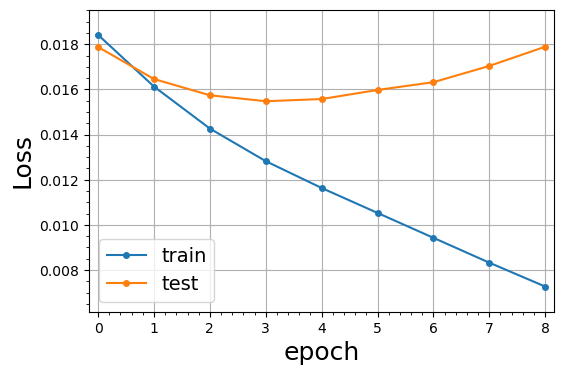

In [37]:
plot_loss(h)

In [38]:
y_train_pred = model.predict(X_train)
y_test_pred  = model.predict(X_test)

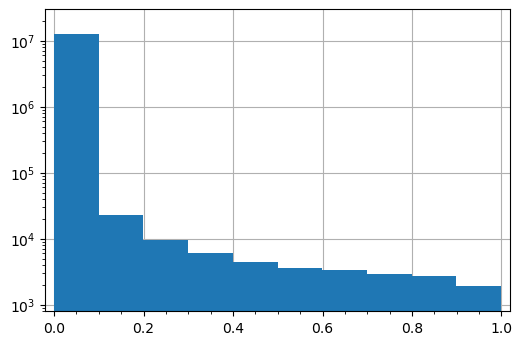

In [39]:
plt.hist(y_test_pred.ravel(),log=True);

In [40]:
x,f,r,p = find_threshold(y_test,y_test_pred)

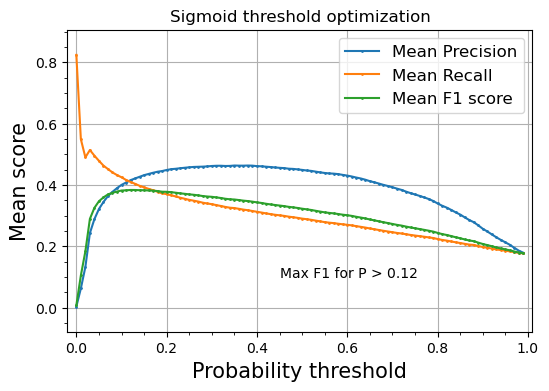

In [41]:
thres = plot_threshold(x,f,r,p)

In [42]:
y_train_pred_class = np.where(y_train_pred > thres, 1, 0)
y_test_pred_class  = np.where(y_test_pred  > thres, 1, 0)

In [43]:
print('train sample:',round(mean_f1_score(y_train,y_train_pred_class),6))
print('test  sample:',round(mean_f1_score(y_test,y_test_pred_class),6))

train sample: 0.450526
test  sample: 0.383692


### 2.4 A simple LSTM <a id='2.4'></a>

Cool. Now let's build the first model. A simple LSTM and a dense layer

In [44]:
model2 = Sequential()
model2.add(LSTM(n_products, activation='relu', input_shape=(last_n_orders,n_products),return_sequences=False))
model2.add(Dense(n_products, activation='sigmoid'))
model2.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 1000)              8004000   
_________________________________________________________________
dense_1 (Dense)              (None, 1000)              1001000   
Total params: 9,005,000
Trainable params: 9,005,000
Non-trainable params: 0
_________________________________________________________________


In [45]:
model2.compile(loss='binary_crossentropy', optimizer='adam')#, metrics=['accuracy'])

In [46]:
%%time

h2 = model2.fit(X_train, y_train,validation_data=(X_test, y_test),epochs=50,callbacks=[callback])

Epoch 1/50
1172/1172 [==============================] - 572s 488ms/step - loss: 0.0260 - val_loss: 0.0202
Epoch 2/50
1172/1172 [==============================] - 572s 488ms/step - loss: 0.0188 - val_loss: 0.0186
Epoch 3/50
1172/1172 [==============================] - 572s 488ms/step - loss: 0.0171 - val_loss: 0.0174
Epoch 4/50
1172/1172 [==============================] - 574s 490ms/step - loss: 0.0154 - val_loss: 0.0165
Epoch 5/50
1172/1172 [==============================] - 574s 490ms/step - loss: 0.0138 - val_loss: 0.0160
Epoch 6/50
1172/1172 [==============================] - 576s 491ms/step - loss: 0.0124 - val_loss: 0.0160
Epoch 7/50
1172/1172 [==============================] - 572s 488ms/step - loss: 0.0111 - val_loss: 0.0166
Epoch 8/50
1172/1172 [==============================] - 573s 489ms/step - loss: 0.0099 - val_loss: 0.0174
Epoch 9/50
1172/1172 [==============================] - 573s 489ms/step - loss: 0.0098 - val_loss: 0.0182
Epoch 10/50
1172/1172 [=======================

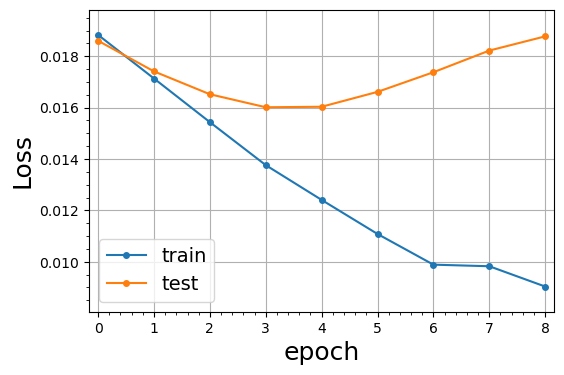

In [47]:
plot_loss(h2)

In [ ]:
#model.save('./data/model211.h5')

In [ ]:
#with open('./data/history211.pkl', 'wb') as f:
#    pickle.dump(h, f)

In [48]:
y_train_pred = model2.predict(X_train)
y_test_pred  = model2.predict(X_test)

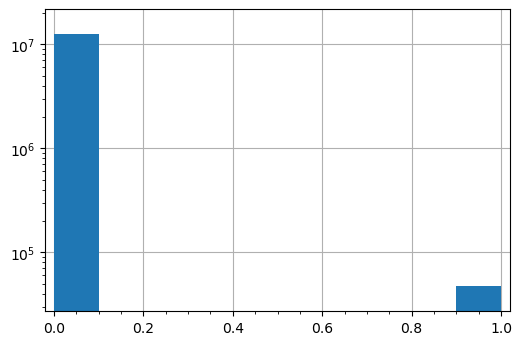

In [49]:
plt.hist(y_test.ravel(),log=True);

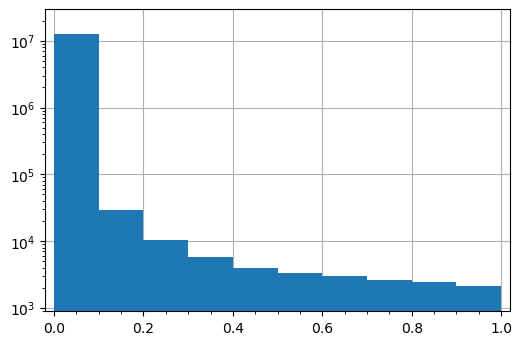

In [50]:
plt.hist(y_test_pred.ravel(),log=True);

Optimize threshold:

In [51]:
x,f,r,p = find_threshold(y_test,y_test_pred)

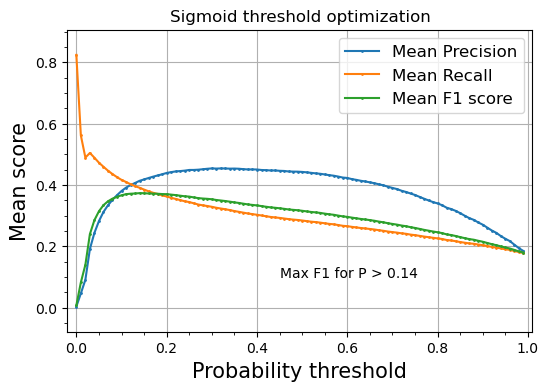

In [52]:
thres = plot_threshold(x,f,r,p)

In [53]:
y_train_pred_class = np.where(y_train_pred > thres, 1, 0)
y_test_pred_class  = np.where(y_test_pred  > thres, 1, 0)

Mean F1 score:

In [54]:
print('train sample:',round(mean_f1_score(y_train,y_train_pred_class),6))
print('test  sample:',round(mean_f1_score(y_test,y_test_pred_class),6))

train sample: 0.435397
test  sample: 0.37342


In [55]:
print('train sample:',round(mean_recall_score(y_train,y_train_pred_class),6))
print('test  sample:',round(mean_recall_score(y_test,y_test_pred_class),6))

train sample: 0.469902
test  sample: 0.39083


In [56]:
print('train sample:',round(mean_precision_score(y_train,y_train_pred_class),6))
print('test  sample:',round(mean_precision_score(y_test,y_test_pred_class),6))

train sample: 0.460252
test  sample: 0.413542


Printout for the i-th customer:

In [57]:
i = 5
print('train:')
print('   true:',np.nonzero(y_train[i]))
print('   pred:',np.nonzero(y_train_pred_class[i]))
print('   common:',np.dot(y_train[i],y_train_pred_class[i]))

print('\n test:')
print('   true:',np.nonzero(y_test[i]))
print('   pred:',np.nonzero(y_test_pred_class[i]))
print('   common:',np.dot(y_test[i],y_test_pred_class[i]))

train:
   true: (array([258, 383, 444, 506, 941]),)
   pred: (array([  7, 444, 506, 892]),)
   common: 2

 test:
   true: (array([103, 506, 575, 754, 850, 918, 973]),)
   pred: (array([262, 444, 506, 617, 842, 902]),)
   common: 1


2 and 3 common

### 2.5 BIdirectional GRU <a id='2.5'></a>

In [59]:
model3 = Sequential()
model3.add(Bidirectional(GRU(n_products, activation='relu',return_sequences=False),input_shape=(last_n_orders,n_products)))
model3.add(Dense(n_products, activation='sigmoid'))
model3.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
bidirectional_1 (Bidirection (None, 2000)              12012000  
_________________________________________________________________
dense_3 (Dense)              (None, 1000)              2001000   
Total params: 14,013,000
Trainable params: 14,013,000
Non-trainable params: 0
_________________________________________________________________


In [60]:
model3.compile(loss='binary_crossentropy', optimizer='adam')#, metrics=['accuracy'])

In [61]:
%%time

h3 = model3.fit(X_train, y_train,validation_data=(X_test, y_test),epochs=50,callbacks=[callback])

Epoch 1/50
1172/1172 [==============================] - 910s 776ms/step - loss: 0.0242 - val_loss: 0.0185
Epoch 2/50
1172/1172 [==============================] - 909s 775ms/step - loss: 0.0165 - val_loss: 0.0163
Epoch 3/50
1172/1172 [==============================] - 994s 849ms/step - loss: 0.0140 - val_loss: 0.0155
Epoch 4/50
1172/1172 [==============================] - 864s 737ms/step - loss: 0.0122 - val_loss: 0.0156
Epoch 5/50
1172/1172 [==============================] - 851s 726ms/step - loss: 0.0106 - val_loss: 0.0158
Epoch 6/50
1172/1172 [==============================] - 851s 726ms/step - loss: 0.0091 - val_loss: 0.0165
Epoch 7/50
1172/1172 [==============================] - 851s 726ms/step - loss: 0.0075 - val_loss: 0.0176
Epoch 8/50
1172/1172 [==============================] - 851s 726ms/step - loss: 0.0060 - val_loss: 0.0194
CPU times: user 13h 50min 53s, sys: 9min 16s, total: 14h 10s
Wall time: 1h 58min 7s


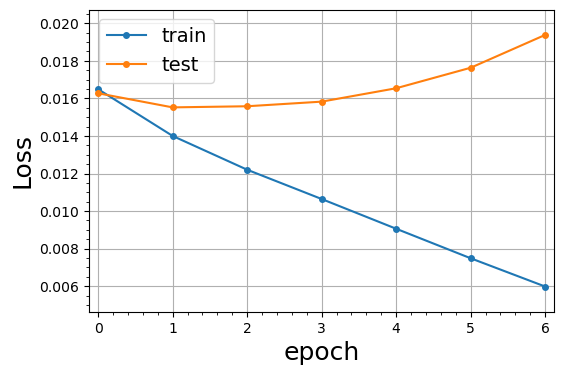

In [62]:
plot_loss(h3)

In [63]:
y_train_pred = model3.predict(X_train)
y_test_pred  = model3.predict(X_test)

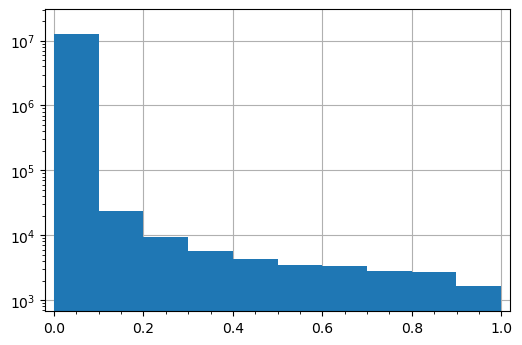

In [64]:
plt.hist(y_test_pred.ravel(),log=True);

In [65]:
x,f,r,p = find_threshold(y_test,y_test_pred)

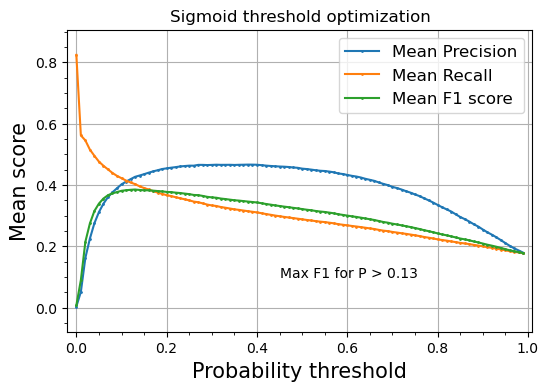

In [66]:
thres = plot_threshold(x,f,r,p)

In [67]:
y_train_pred_class = np.where(y_train_pred > thres, 1, 0)
y_test_pred_class  = np.where(y_test_pred  > thres, 1, 0)

In [68]:
print('train sample:',round(mean_f1_score(y_train,y_train_pred_class),6))
print('test  sample:',round(mean_f1_score(y_test,y_test_pred_class),6))

train sample: 0.441232
test  sample: 0.385201


### 2.6 Bidirectional LSTM <a id='2.6'></a>

In [69]:
model4 = Sequential()
model4.add(Bidirectional(LSTM(n_products, activation='relu',return_sequences=False), input_shape=(last_n_orders,n_products)))
model4.add(Dense(n_products, activation='sigmoid'))
model4.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
bidirectional_2 (Bidirection (None, 2000)              16008000  
_________________________________________________________________
dense_4 (Dense)              (None, 1000)              2001000   
Total params: 18,009,000
Trainable params: 18,009,000
Non-trainable params: 0
_________________________________________________________________


In [70]:
model4.compile(loss='binary_crossentropy', optimizer='adam')#, metrics=['accuracy'])

In [71]:
%%time

h4 = model4.fit(X_train, y_train,validation_data=(X_test, y_test),epochs=50,callbacks=[callback])

Epoch 1/50
1172/1172 [==============================] - 1103s 941ms/step - loss: 0.0289 - val_loss: 0.0201
Epoch 2/50
1172/1172 [==============================] - 1103s 941ms/step - loss: 0.0189 - val_loss: 0.0185
Epoch 3/50
1172/1172 [==============================] - 1104s 942ms/step - loss: 0.0169 - val_loss: 0.0173
Epoch 4/50
1172/1172 [==============================] - 1104s 942ms/step - loss: 0.0150 - val_loss: 0.0163
Epoch 5/50
1172/1172 [==============================] - 1104s 942ms/step - loss: 0.0131 - val_loss: 0.0161
Epoch 6/50
1172/1172 [==============================] - 1104s 942ms/step - loss: 0.0116 - val_loss: 0.0161
Epoch 7/50
1172/1172 [==============================] - 1104s 942ms/step - loss: 0.0103 - val_loss: 0.0168
Epoch 8/50
1172/1172 [==============================] - 1105s 943ms/step - loss: 0.0090 - val_loss: 0.0175
Epoch 9/50
1172/1172 [==============================] - 1104s 942ms/step - loss: 0.0079 - val_loss: 0.0185
Epoch 10/50
1172/1172 [==============

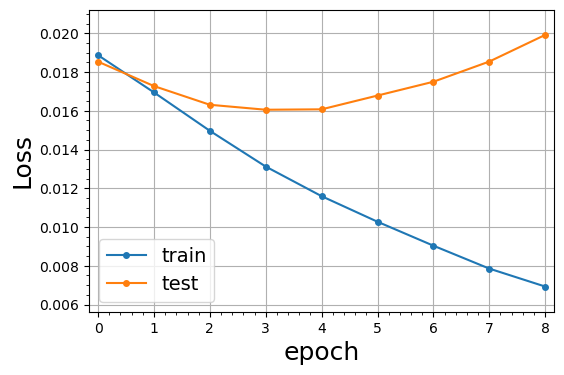

In [72]:
plot_loss(h4)

In [73]:
y_train_pred = model4.predict(X_train)
y_test_pred  = model4.predict(X_test)

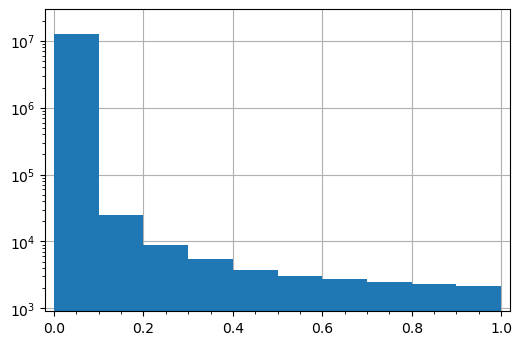

In [74]:
plt.hist(y_test_pred.ravel(),log=True);

In [75]:
x,f,r,p = find_threshold(y_test,y_test_pred)

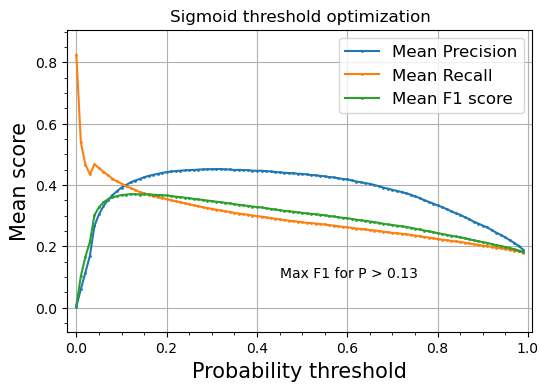

In [76]:
thres = plot_threshold(x,f,r,p)

In [77]:
y_train_pred_class = np.where(y_train_pred > thres, 1, 0)
y_test_pred_class  = np.where(y_test_pred  > thres, 1, 0)

In [78]:
print('train sample:',round(mean_f1_score(y_train,y_train_pred_class),6))
print('test  sample:',round(mean_f1_score(y_test,y_test_pred_class),6))

train sample: 0.451894
test  sample: 0.37024


### 2.7 Stacked LSTM <a id='2.7'></a>

inspired by this post [https://stackabuse.com/solving-sequence-problems-with-lstm-in-keras-part-2/](https://stackabuse.com/solving-sequence-problems-with-lstm-in-keras-part-2/), 

section "Many-to-Many Sequence Problems with Multiple Features":

In [81]:
model5 = Sequential()
model5.add(LSTM(n_products, activation='relu', input_shape=(last_n_orders,n_products)))
model5.add(RepeatVector(last_n_orders))
model5.add(LSTM(n_products, activation='relu',return_sequences=False))
model5.add(Dense(n_products, activation='sigmoid'))
model5.summary()

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_3 (LSTM)                (None, 1000)              8004000   
_________________________________________________________________
repeat_vector (RepeatVector) (None, 20, 1000)          0         
_________________________________________________________________
lstm_4 (LSTM)                (None, 1000)              8004000   
_________________________________________________________________
dense_5 (Dense)              (None, 1000)              1001000   
Total params: 17,009,000
Trainable params: 17,009,000
Non-trainable params: 0
_________________________________________________________________


In [85]:
model5.compile(loss='binary_crossentropy', optimizer='adam')#, metrics=['accuracy'])

In [86]:
%%time

h5 = model5.fit(X_train, y_train,validation_data=(X_test, y_test),epochs=50,callbacks=[callback])

Epoch 1/50
1172/1172 [==============================] - 1236s 1s/step - loss: 0.0199 - val_loss: 0.0194
Epoch 2/50
1172/1172 [==============================] - 1272s 1s/step - loss: 0.0183 - val_loss: 0.0184
Epoch 3/50
1172/1172 [==============================] - 1274s 1s/step - loss: 0.0170 - val_loss: 0.0179
Epoch 4/50
1172/1172 [==============================] - 1249s 1s/step - loss: 0.0157 - val_loss: 0.0177
Epoch 5/50
1172/1172 [==============================] - 1285s 1s/step - loss: 0.0144 - val_loss: 0.0177
Epoch 6/50
1172/1172 [==============================] - 1253s 1s/step - loss: 0.0136 - val_loss: 0.0182
Epoch 7/50
1172/1172 [==============================] - 1251s 1s/step - loss: 9.0744 - val_loss: 0.0185
Epoch 8/50
1172/1172 [==============================] - 1239s 1s/step - loss: 169.4120 - val_loss: 41.4905
Epoch 9/50
1172/1172 [==============================] - 1235s 1s/step - loss: 183.1527 - val_loss: 20.1653
CPU times: user 21h 14min 38s, sys: 20min 8s, total: 21h 3

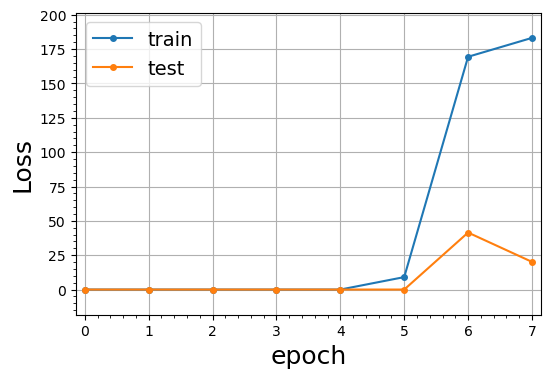

In [87]:
plot_loss(h5)

In [88]:
y_train_pred = model5.predict(X_train)
y_test_pred  = model5.predict(X_test)

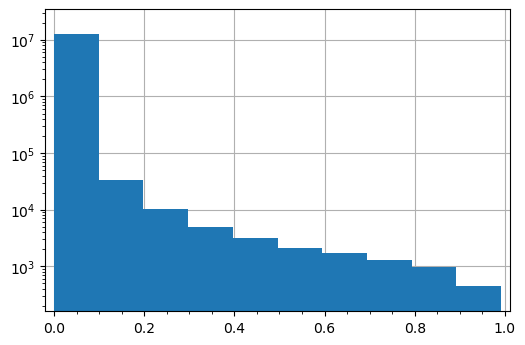

In [89]:
plt.hist(y_test_pred.ravel(),log=True);

In [90]:
x,f,r,p = find_threshold(y_test,y_test_pred)

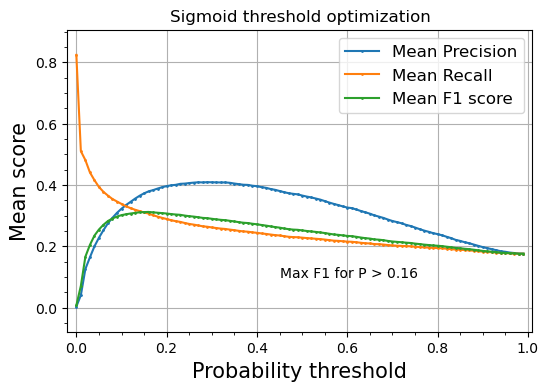

In [91]:
thres = plot_threshold(x,f,r,p)

In [92]:
y_train_pred_class = np.where(y_train_pred > thres, 1, 0)
y_test_pred_class  = np.where(y_test_pred  > thres, 1, 0)

Mean F1 score:

In [93]:
print('train sample:',round(mean_f1_score(y_train,y_train_pred_class),6))
print('test  sample:',round(mean_f1_score(y_test,y_test_pred_class),6))

train sample: 0.38667
test  sample: 0.312133


### 2.8 Summary <a id='2.8'></a>

The simple LSTM model gives the best result, the mean F1 = 0.41. For GRU models, the bidirectional GRU gives slightly better result than the simple GRU, 0.385 vs 0.384. But this is what we would get by simply copying customer's last order, see [Sec. 2.2](#2.2). Stacked LSTMs are not a good architecture for this problem (score of 0.31 only).